In [1]:
import os
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.types import * 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, asc,desc
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from pyspark.sql import SQLContext
from pyspark.mllib.stat import Statistics
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix

spark=SparkSession.builder \
.master ("local[*]")\
.appName("Mini Project 2")\
.getOrCreate()

In [2]:
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Load data into data frame

In [3]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("data/XYZ_Bank_Deposit_Data_Classification.csv")

In [4]:
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


### Replace periods in column names with underscores

In [5]:
#replace periods in column names with underscores
df = df.toDF(*(c.replace('.', '_') for c in df.columns))

df.toPandas().head(4)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Identify categorical columns and numerical columns

In [6]:
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
print("Total catagorical Columns: " , len(str_cols))
print(str_cols)

dbl_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, DoubleType) | isinstance(f.dataType, IntegerType)]
print("Total numerical Columns: ", len(dbl_cols))
print(dbl_cols)

Total catagorical Columns:  11
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Total numerical Columns:  10
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']


### Check out cardinality and null values for each feature

In [7]:
for col in df.columns:
    print(col, ":\n ", df.filter(df[col]=="?").count(), "null values\n ", df.select(col).distinct().count(), " distinct values")
    print

age :
  0 null values
  78  distinct values
job :
  0 null values
  12  distinct values
marital :
  0 null values
  4  distinct values
education :
  0 null values
  8  distinct values
default :
  0 null values
  3  distinct values
housing :
  0 null values
  3  distinct values
loan :
  0 null values
  3  distinct values
contact :
  0 null values
  2  distinct values
month :
  0 null values
  10  distinct values
day_of_week :
  0 null values
  5  distinct values
duration :
  0 null values
  1544  distinct values
campaign :
  0 null values
  42  distinct values
pdays :
  0 null values
  27  distinct values
previous :
  0 null values
  8  distinct values
poutcome :
  0 null values
  3  distinct values
emp_var_rate :
  0 null values
  10  distinct values
cons_price_idx :
  0 null values
  26  distinct values
cons_conf_idx :
  0 null values
  26  distinct values
euribor3m :
  0 null values
  316  distinct values
nr_employed :
  0 null values
  11  distinct values
y :
  0 null values
  2  di

### Distribution of features

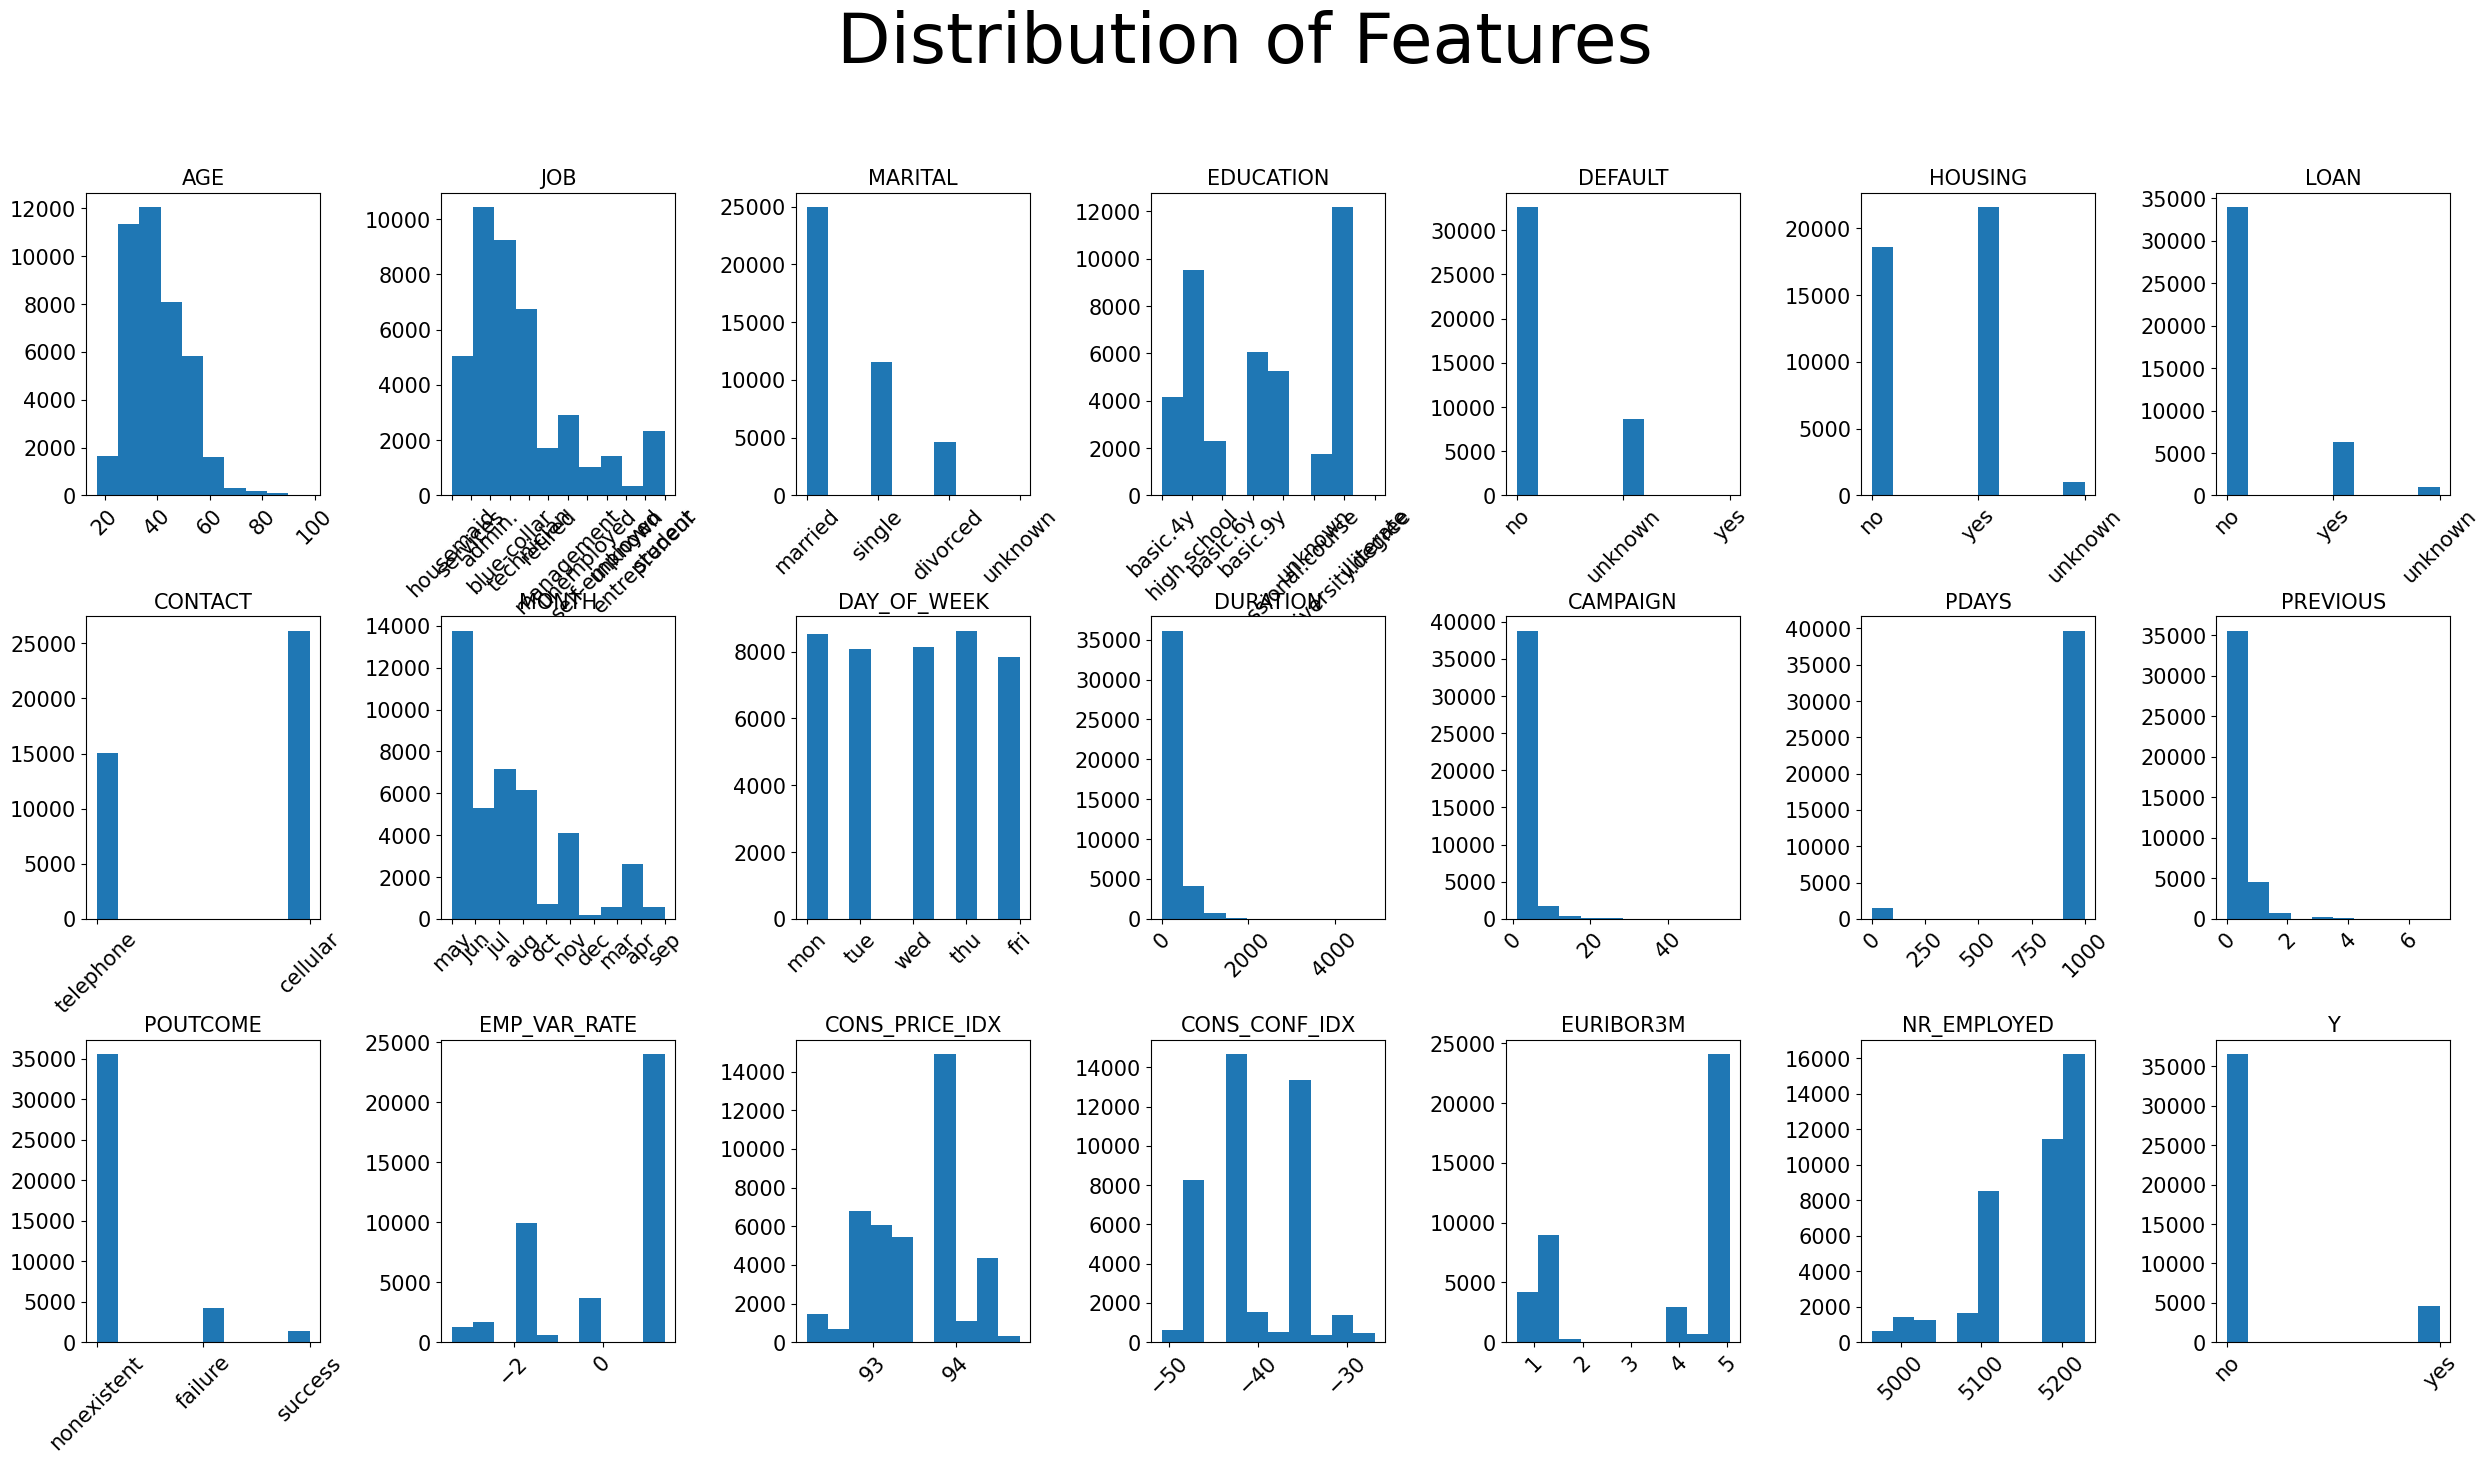

In [8]:
#distribution of features
from matplotlib import cm
fig = plt.figure(figsize=(25,15)) ## Plot Size 
st = fig.suptitle("Distribution of Features", fontsize=50,
                  verticalalignment='center') # Plot Main Title 

for col,num in zip(df.toPandas().columns, range(1,22)):

    ax = fig.add_subplot(3,7,num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=15)
plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85,hspace = 0.4)
plt.show()

### Double check null values

In [9]:
from pyspark.sql.functions import isnan, when, count, col
print(df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().head())

   age  job  marital  education  default  housing  loan  contact  month  \
0    0    0        0          0        0        0     0        0      0   

   day_of_week  ...  campaign  pdays  previous  poutcome  emp_var_rate  \
0            0  ...         0      0         0         0             0   

   cons_price_idx  cons_conf_idx  euribor3m  nr_employed  y  
0               0              0          0            0  0  

[1 rows x 21 columns]


### Split data between train and test

In [10]:
# train/test split
train, test = df.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

train.groupby("y").count().show()

Training Dataset Count: 32894
Test Dataset Count: 8294
+---+-----+
|  y|count|
+---+-----+
| no|29196|
|yes| 3698|
+---+-----+



### Data Preprocessing
##### One Hot encoding of categorical features, vectorizing all features, scale features and add models

In [11]:
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
stages = []
preprocessStages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index', handleInvalid='keep')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    preprocessStages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
preprocessStages += [label_stringIdx]
numericCols = dbl_cols
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vectorized_features", handleInvalid="skip") # use setHandleInvalid("skip")
preprocessStages += [assembler]
scaler = StandardScaler(inputCol="vectorized_features", outputCol="features")
preprocessStages += [scaler]

from pyspark.ml.classification import LogisticRegression, RandomForestClassificationModel, RandomForestClassifier, DecisionTreeClassifier,LinearSVC, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5, predictionCol = 'lr_prediction', rawPredictionCol ='lr_rawPrediction', probabilityCol='lr_probability')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', predictionCol = 'rf_prediction', rawPredictionCol='rf_rawPrediction', probabilityCol='rf_probability')
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label", predictionCol = 'dtc_prediction', rawPredictionCol='dtc_rawPrediction', probabilityCol='dtc_probability')
lsvc = LinearSVC(labelCol="label", maxIter=50, predictionCol = 'lsvc_prediction', rawPredictionCol='lsvc_rawPrediction')
gbtr = GBTClassifier(featuresCol='features', labelCol='label', maxIter=10, predictionCol = 'gbtr_prediction', cacheNodeIds = True)

stages += [lr]
stages += [rf]
stages += [dtc]
stages += [lsvc]
stages += [gbtr]

cols = df.columns
print(cols)
print(stages)
print(preprocessStages)

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
[LogisticRegression_17d1e52800f8, RandomForestClassifier_5c012fdf5df0, DecisionTreeClassifier_a06020c0d12f, LinearSVC_c8c4e95a3eb0, GBTClassifier_061aeeda59b0]
[StringIndexer_dfeff570e61f, OneHotEncoder_cfffbf714d11, StringIndexer_e958e9a36496, OneHotEncoder_606b1ff5b106, StringIndexer_7a3c96d22a7f, OneHotEncoder_46977205097c, StringIndexer_c89d473ea20b, OneHotEncoder_529c017858cc, StringIndexer_3f14f70b479e, OneHotEncoder_2db76cfebfdc, StringIndexer_386f801ca1c0, OneHotEncoder_2b47bd44cd19, StringIndexer_aecbc3a0d9d8, OneHotEncoder_206ba6b26602, StringIndexer_92ab5bba110f, OneHotEncoder_aef3e06a5575, StringIndexer_10c6325f5bb2, OneHotEncoder_e866d9371208, StringIndexer_ab1f72c67cdd, OneHotEncoder_e741191280e6, StringIndexer_e58b08549a21, Vector

### Train the models

In [12]:
pipeline = Pipeline(stages = preprocessStages + stages)
pipelineModel = pipeline.fit(train)
pipelinePredictions = pipelineModel.transform(test)

print(pipelinePredictions.toPandas().head())

   age      job marital    education default housing loan    contact month  \
0   18  student  single  high.school      no      no   no  telephone   nov   
1   19  student  single      unknown      no      no   no   cellular   apr   
2   19  student  single      unknown      no     yes   no   cellular   apr   
3   19  student  single      unknown      no     yes   no   cellular   apr   
4   19  student  single      unknown      no     yes  yes   cellular   apr   

  day_of_week  ...                             rf_probability  rf_prediction  \
0         thu  ...  [0.9458923267156998, 0.05410767328430029]            0.0   
1         fri  ...   [0.880855259912491, 0.11914474008750897]            0.0   
2         fri  ...   [0.8383664245537071, 0.1616335754462928]            0.0   
3         mon  ...   [0.880855259912491, 0.11914474008750897]            0.0   
4         fri  ...   [0.880855259912491, 0.11914474008750897]            0.0   

   dtc_rawPrediction                             d

### Show prediction and probability for each trained model

In [13]:
#*************************
#* Model
#*************************

#predictions_train = lrModel.transform(train)
print("Logistic Regression")
print(pipelinePredictions.select('label', 'features',  'lr_rawPrediction', 'lr_prediction', 'lr_probability').toPandas().head(5))
print("Random Forest")
print(pipelinePredictions.select('label', 'features', 'rf_rawPrediction',  'rf_prediction', 'rf_probability').toPandas().head(5))
print("Decision Tree")
print(pipelinePredictions.select('label', 'features',  'dtc_rawPrediction', 'dtc_prediction', 'dtc_probability').toPandas().head(5))
print("Linear SVC")
print(pipelinePredictions.select('label', 'features', 'lsvc_rawPrediction',  'lsvc_prediction').toPandas().head(5))
print("Gradiant Boosted")
print(pipelinePredictions.select('label', 'features','gbtr_prediction').toPandas().head(5))

# End Model

Logistic Regression
   label                                           features  \
0    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2    1.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                              lr_rawPrediction  lr_prediction  \
0      [3.523400226915875, -3.523400226915875]            0.0   
1    [1.8925372114492518, -1.8925372114492518]            0.0   
2  [0.49650725332154977, -0.49650725332154977]            0.0   
3    [1.7127428207080069, -1.7127428207080069]            0.0   
4    [2.0572863811474136, -2.0572863811474136]            0.0   

                              lr_probability  
0  [0.971346293299115, 0.028653706700884962]  
1  [0.8690445512178763, 0.13095544878212373]  
2   [0.6216381723758556, 0.3783618276241444]  
3   [0.847191702340079

### Function definition for confusion matrix graph

In [14]:
class_names=[1.0,0.0]   
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

### Confusion Matrix and ROC for Logistical Regression 

Confusion matrix, without normalization
[[ 399  543]
 [ 179 7173]]


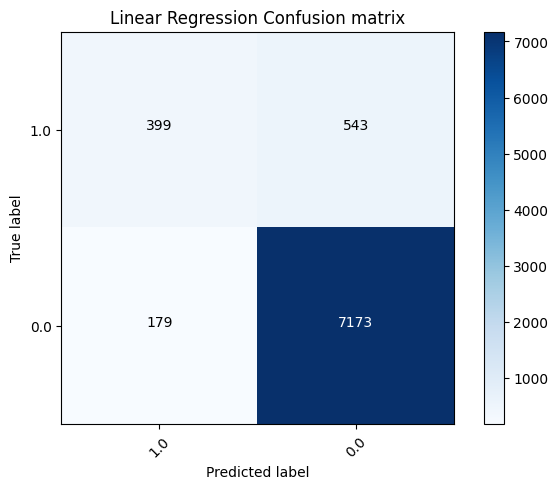

Accuracy :  0.9129491198456716


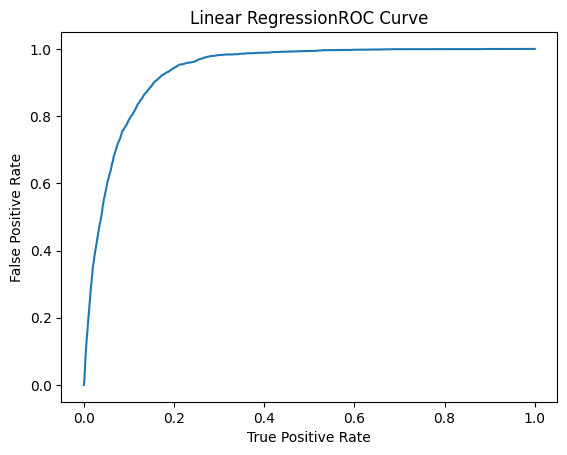

Training set areaUnderROC: 0.935075829045533


In [15]:
y_true = pipelinePredictions.select("label")
y_true = y_true.toPandas()

y_pred = pipelinePredictions.select("lr_prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Linear Regression Confusion matrix')
plt.show()

accuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.lr_prediction).count() / float(pipelinePredictions.count())
print("Accuracy : ",accuracy)

trainingSummary = pipelineModel.stages[-5].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Linear RegressionROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Confusion Matrix and ROC for Random Forest

Confusion matrix, without normalization
[[ 163  779]
 [  47 7305]]


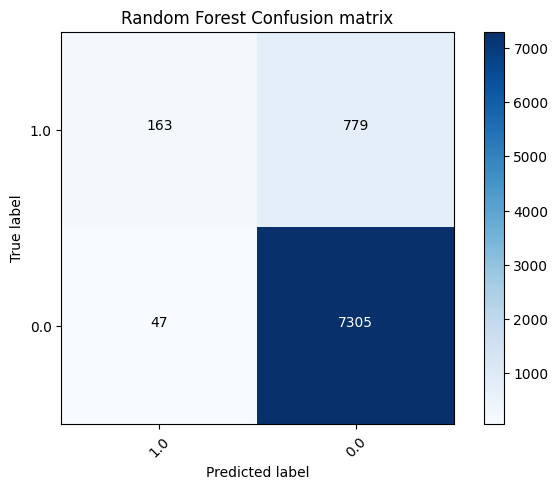

Accuracy :  0.9004099348926935


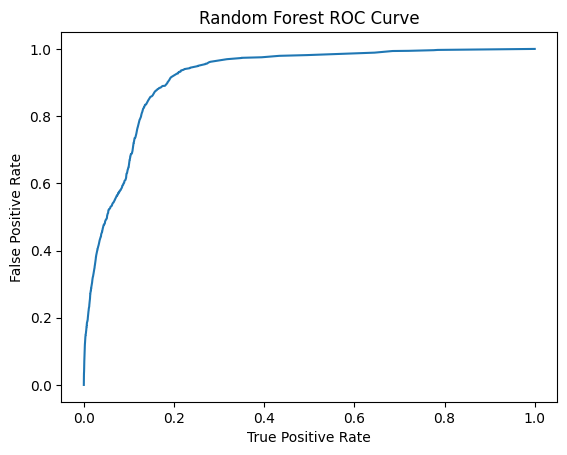

Training set areaUnderROC: 0.9155213980207694


In [16]:
y_true = pipelinePredictions.select("label")
y_true = y_true.toPandas()

y_pred = pipelinePredictions.select("rf_prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random Forest Confusion matrix')
plt.show()

accuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.rf_prediction).count() / float(pipelinePredictions.count())
print("Accuracy : ",accuracy)

trainingSummary = pipelineModel.stages[-4].summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Function Definition for ROC curve graph for Decion Tree and Gradient Boosted Tree

In [17]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

### Confusion Matrix and ROC for Decision Tree

Confusion matrix, without normalization
[[ 520  422]
 [ 266 7086]]


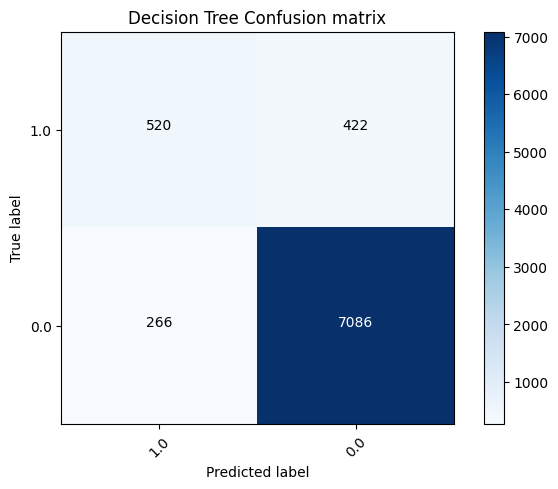

Accuracy :  0.9170484687726067


C:\apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


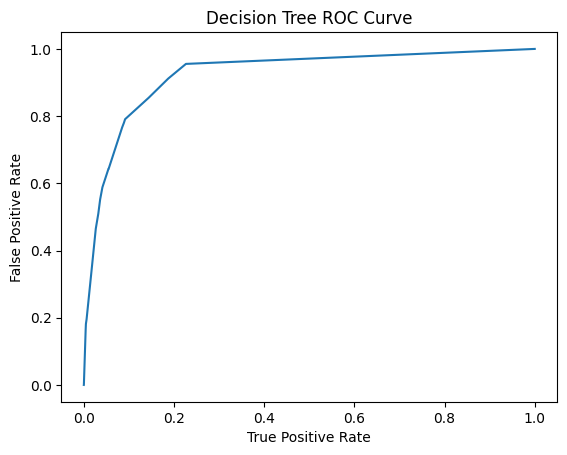

Training set areaUnderROC: 0.9316679252016038


In [30]:
y_true = pipelinePredictions.select("label")
y_true = y_true.toPandas()

y_pred = pipelinePredictions.select("dtc_prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Decision Tree Confusion matrix')
plt.show()

accuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.dtc_prediction).count() / float(pipelinePredictions.count())
print("Accuracy : ",accuracy)

# Returns as a list (false positive rate, true positive rate)
preds = pipelinePredictions.select('label','dtc_probability').rdd.map(lambda row: (float(row['dtc_probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot(x_val, y_val)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### confusion Matrix and ROC for Linear SVC

Confusion matrix, without normalization
[[ 291  651]
 [ 159 7193]]


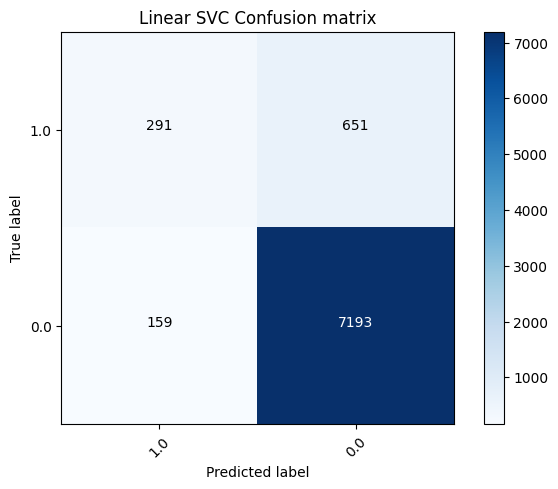

Accuracy :  0.9023390402700747


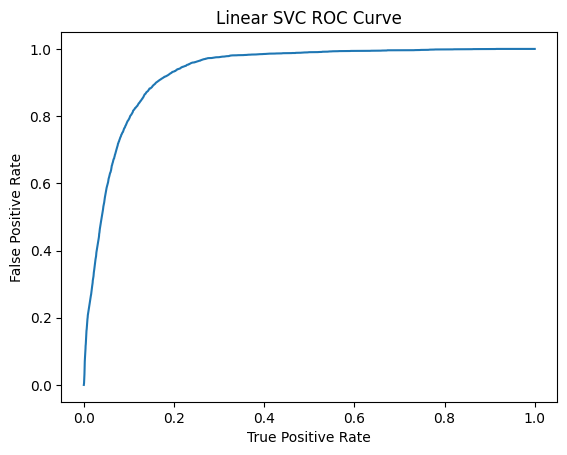

Training set areaUnderROC: 0.9316679252016038


In [19]:
y_true = pipelinePredictions.select("label")
y_true = y_true.toPandas()

y_pred = pipelinePredictions.select("lsvc_prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Linear SVC Confusion matrix')
plt.show()

accuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.lsvc_prediction).count() / float(pipelinePredictions.count())
print("Accuracy : ",accuracy)

trainingSummary = pipelineModel.stages[-2].summary()
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Linear SVC ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Confusion Matrix and ROC for Gradient Boosted Tree

Confusion matrix, without normalization
[[ 505  437]
 [ 228 7124]]


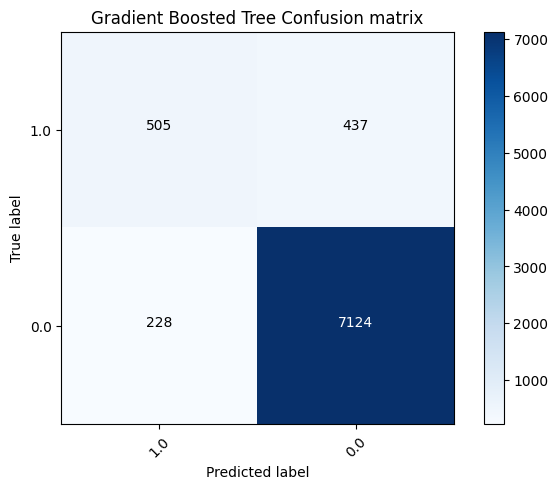

Accuracy :  0.9198215577525922


C:\apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


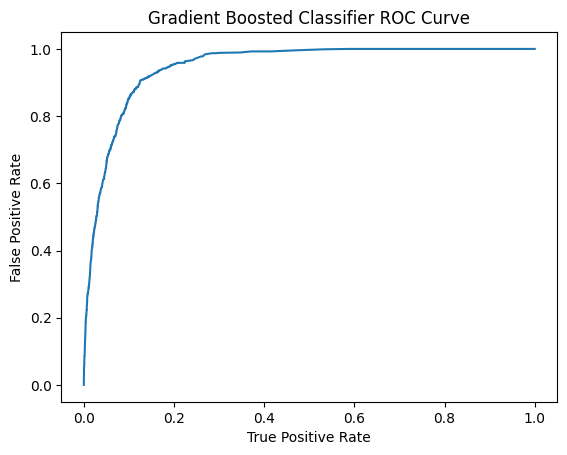

Training set areaUnderROC: 0.9316679252016038


In [20]:
y_true = pipelinePredictions.select("label")
y_true = y_true.toPandas()

y_pred = pipelinePredictions.select("gbtr_prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Gradient Boosted Tree Confusion matrix')
plt.show()

accuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.gbtr_prediction).count() / float(pipelinePredictions.count())
print("Accuracy : ",accuracy)

# Returns as a list (false positive rate, true positive rate)
preds = pipelinePredictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.plot(x_val, y_val)
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Gradient Boosted Classifier ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Accuracy statistics for all models

In [21]:
lraccuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.lr_prediction).count() / float(pipelinePredictions.count())
print("Logistical Regression Accuracy : ",lraccuracy)

rfaccuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.rf_prediction).count() / float(pipelinePredictions.count())
print("Random Forrest Accuracy : ",rfaccuracy)

dtcaccuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.dtc_prediction).count() / float(pipelinePredictions.count())
print("Decision TreeAccuracy : ",dtcaccuracy)

lsvcaccuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.lsvc_prediction).count() / float(pipelinePredictions.count())
print("Linear SVC Accuracy : ",lsvcaccuracy)

gbtraccuracy = pipelinePredictions.filter(pipelinePredictions.label == pipelinePredictions.gbtr_prediction).count() / float(pipelinePredictions.count())
print("Gradient Boosted Tree Accuracy : ",gbtraccuracy)

Logistical Regression Accuracy :  0.9129491198456716
Random Forrest Accuracy :  0.9004099348926935
Decision TreeAccuracy :  0.9170484687726067
Linear SVC Accuracy :  0.9023390402700747
Gradient Boosted Tree Accuracy :  0.9198215577525922


### Instatiate evaluator for GBT since it had the best accuracy statistics

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
gbtrevaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction')

gbtrpipeline = Pipeline(stages = preprocessStages + [gbtr])

### Set up hyper parameters and cross validate

In [23]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder()\
  .addGrid(gbtr.maxDepth, [2, 5])\
  .addGrid(gbtr.maxIter, [10, 100])\
  .build()

cv = CrossValidator(estimator=gbtrpipeline, estimatorParamMaps=paramGrid,
                    evaluator=gbtrevaluator, numFolds=5)

cvModel = cv.fit(train)

### Evaluate best model

In [24]:
## Evaluate Best Model
predictions = cvModel.transform(test)
print('Best Model Test Area Under ROC', gbtrevaluator.evaluate(predictions))

Best Model Test Area Under ROC 0.9523800447731176


In [25]:
cvModel.bestModel

PipelineModel_3868e9e12300

### Evaluate feature weights

In [26]:
weights = cvModel.bestModel.stages[-1].featureImportances
weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ["Feature Weight"])
weightsDF.toPandas().head(54)

,Feature Weight
0,0.003356
1,0.004975
2,0.007054
3,0.004956
4,0.004255
5,0.006252
6,0.004233
7,0.003942
8,0.004052
9,0.003862


In [27]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [28]:
predictions.toPandas()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,day_of_weekIndex,day_of_weekclassVec,poutcomeIndex,poutcomeclassVec,label,vectorized_features,features,rawPrediction,probability,gbtr_prediction
0,18,student,single,high.school,no,no,no,telephone,nov,thu,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.682811436503495, -1.682811436503495]","[0.9666127181693811, 0.0333872818306189]",0.0
1,19,student,single,unknown,no,no,no,cellular,apr,fri,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5933225730669438, -0.5933225730669438]","[0.7661405144277466, 0.23385948557225344]",0.0
2,19,student,single,unknown,no,yes,no,cellular,apr,fri,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.564392212239783, -0.564392212239783]","[0.7556144991795867, 0.24438550082041333]",0.0
3,19,student,single,unknown,no,yes,no,cellular,apr,mon,...,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.36753356606903675, -0.36753356606903675]","[0.6759162334279896, 0.32408376657201043]",0.0
4,19,student,single,unknown,no,yes,yes,cellular,apr,fri,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4383957005912993, -1.4383957005912993]","[0.9466871556476801, 0.053312844352319866]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8289,88,retired,married,basic.4y,no,yes,no,cellular,sep,mon,...,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 5.021094308348585, 0...","[0.8450076792539856, -0.8450076792539856]","[0.8442261796587766, 0.15577382034122345]",0.0
8290,91,retired,married,university.degree,no,no,yes,cellular,sep,wed,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 5.021094308348585, 0...","[0.08764808784768467, -0.08764808784768467]","[0.5437121661929394, 0.4562878338070606]",0.0
8291,92,retired,married,unknown,no,no,yes,cellular,aug,wed,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0)",2.0,"(0.0, 0.0, 1.0)",1.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 5.021094308348585, 0...","[-1.296347834812204, 1.296347834812204]","[0.06960999665014725, 0.9303900033498528]",1.0
8292,92,retired,married,unknown,no,yes,no,cellular,may,thu,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0)",2.0,"(0.0, 0.0, 1.0)",0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 5.021094308348585, 0...","[-0.858432419475871, 0.858432419475871]","[0.15227543309759395, 0.847724566902406]",1.0


In [29]:
ExtractFeatureImp(cvModel.bestModel.stages[-1].featureImportances, predictions, "features").head(10)

KeyError: 'attrs'

### Save Pickle file

In [ ]:
cvModel.bestModel.save('models/lrModel2.obj')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\smcdaniel\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\smcdaniel\AppData\Local\Temp\ipykernel_15944\558109092.py", line 1, in <module>
    cvModel.bestModel.save('models/lrModel2.obj')
  File "c:\Users\smcdaniel\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\ml\util.py", line 246, in save
    self.write().save(path)
  File "c:\Users\smcdaniel\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\ml\util.py", line 197, in save
    self._jwrite.save(path)
  File "c:\Users\smcdaniel\AppData\Local\Programs\Python\Python310\lib\site-packages\py4j\java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "c:\Users\smcdaniel\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\sql\utils.py", line 190, in deco
    return f(*a, **kw)
  File "c:\